# Testing batdetect2 pipeline features:

## **Working on features relevant to the use of this pipeline on recovered Audiomoth .wav recordings**

## 1) Figuring out our imports:

### a) Below are the imports pertaining to accessing data and metadata

In [74]:
from pathlib import Path
import exiftool

### b) Below are the imports pertaining to data manipulation

In [75]:
import numpy as np
import pandas as pd

### c) Below are the imports pertaining to data visualization

In [76]:
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime as dt

### d) Below are the imports pertaining to the use of the MSDS pipeline

In [77]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

from src.cfg import get_config
from src.pipeline import pipeline
import src.batdt2_pipeline as batdetect2_pipeline

## 2) Initializing our required variables:

### a) Below we initialize our input/output directories and output pipeline csv name

In [91]:
dirpath = f"{Path.home()}/Documents/Research/Symposium/Recordings/recover-20220828/UBNA_010"

recover_folder = dirpath.split('/')[-2]
recover_date = recover_folder.split('-')[1]
audiomoth_folder = dirpath.split('/')[-1]
audiomoth_unit = audiomoth_folder.split('_')[-1]

save_dir = f'../output_dir/{recover_folder}/{audiomoth_folder}'
detfile_name = f'batdetect2_pipeline__{recover_folder}_{audiomoth_folder}'

[dirpath, save_dir, detfile_name]

['/Users/adityakrishna/Documents/Research/Symposium/Recordings/recover-20220828/UBNA_010',
 '../output_dir/recover-20220828/UBNA_010',
 'batdetect2_pipeline__recover-20220828_UBNA_010']

### b) Below we initialize our field records depending on what year our data is from to gather the site name

In [92]:
if str(dt.datetime.strptime(recover_date, "%Y%m%d").year) == "2022":
    field_records = batdetect2_pipeline.get_field_records(Path(f"../field_records/ubna_2022b.csv"))
if str(dt.datetime.strptime(recover_date, "%Y%m%d").year) == "2023":
    field_records = batdetect2_pipeline.get_field_records(Path(f"../field_records/ubna_2023.csv"))

site_name = batdetect2_pipeline.get_site_name(field_records, recover_date, audiomoth_unit)
site_name

'Central Pond'

## 3) Test any main pipeline functions using the initialized variables

### a) Below we test-run our pipeline using the main `run_pipeline()` command in `src/batdt2_pipeline.py`

In [62]:
### b) Below we initialize our field records depending on what year our data is from to gather the site name

### b) Below is the function that will be used in our pipeline to plot the activity plots; Use it to test the overall function

In [63]:
# batdetect2_pipeline.plot_dets_as_activity_grid(dirpath, f"{detfile_name}.csv", save_dir, site_name, show_PST=True, save=False)

## 4) Develop any of the main functions below:

### a) Below is the code for plotting activity; it has been developed to include:

- PST functionality with axis labels for UTC/PST
- Plotting site name in title of activity
- Aligning ticks and grid lines to feel intuitive
- Masking values that are 0 implying there was an error collecting that time's recording

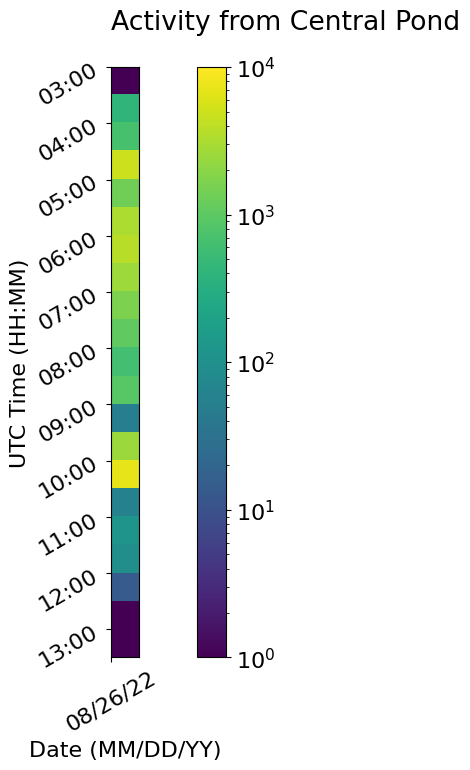

In [98]:
recover_folder = dirpath.split('/')[-2]
audiomoth_folder = dirpath.split('/')[-1]
dets = pd.read_csv(f'{save_dir}/{detfile_name}.csv')
activity = np.array([])
show_PST = False
activity_times = []
activity_dates = []

for file in batdetect2_pipeline.get_files_for_pipeline(dirpath):
    filedets = dets.loc[dets['input_file']==Path(file).name]
    activity = np.hstack([activity, len(filedets)+1])

    file_dt_UTC = dt.datetime.strptime(Path(file).name, "%Y%m%d_%H%M%S.WAV")

    if show_PST:
        if (file_dt_UTC.hour >= 7):
            file_dt_PST = dt.datetime.strptime(f"{file_dt_UTC.date()}_{str(file_dt_UTC.hour - 7).zfill(2)}{file_dt_UTC.minute}", "%Y-%m-%d_%H%M")
            file_time_PST = dt.datetime.strftime(file_dt_PST, "%H:%M")
        else:
            file_dt_PST = dt.datetime.strptime(f"{file_dt_UTC.date()}_{str(24 + file_dt_UTC.hour - 7).zfill(2)}{file_dt_UTC.minute}", "%Y-%m-%d_%H%M")
            file_time_PST = dt.datetime.strftime(file_dt_PST, "%H:%M")
        if (not(activity_times.__contains__(file_time_PST))):
            activity_times.append(file_time_PST)
    else:
        file_time_UTC = dt.datetime.strftime(file_dt_UTC, "%H:%M")
        if (not(activity_times.__contains__(file_time_UTC))):
            activity_times.append(file_time_UTC)

    file_date = dt.datetime.strftime(file_dt_UTC, "%m/%d/%y")
    if (not(activity_dates.__contains__(file_date))):
        activity_dates.append(file_date)

activity = activity.reshape((len(activity_times), len(activity_dates)))
# activity = activity.reshape((len(activity_dates), len(activity_times))).T

# activity[1:-1:6] = 0
# activity[2:-1:6] = 0
# activity[3:-1:6] = 0

masked_array_for_nodets = np.ma.masked_where(activity==0, activity)
cmap = plt.get_cmap('viridis')
cmap.set_bad(color='red', alpha=1.0)

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12, 8))
plt.title(f"Activity from {site_name}", loc='left', y=1.05)
plt.imshow(masked_array_for_nodets, cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=10e3))
plt.yticks(np.arange(0, len(activity_times), 2)-0.5, activity_times[::2], rotation=30)
plt.xticks(np.arange(0, len(activity_dates))-0.5, activity_dates, rotation=30)
plt.ylabel('UTC Time (HH:MM)')
plt.xlabel('Date (MM/DD/YY)')
plt.colorbar()
plt.tight_layout()
plt.show()

### b) Below is the code for using exiftool to skip error files in our pipeline

- Starting to learn how to use exiftool or PyExifTool 
- Implementing checks for error files using Audiomoth .wav metadata
- Incorporating checks into generate_segments() function so pipeline only generates segments for valid recordings

#### Initialize the set of test files we need to analyze

- Some of them will be error files
- Some of them will be usable files

In [67]:
dirpath = f"{Path.home()}/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001"
files = batdetect2_pipeline.get_files_to_reference(dirpath)
files

[PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_030000.WAV'),
 PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_053000.WAV'),
 PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_060000.WAV'),
 PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_063000.WAV'),
 PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_073000.WAV'),
 PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_090000.WAV')]

#### Print the metadata of a single Audiomoth recording

In [68]:
exiftool.ExifToolHelper().get_metadata(files)[4]

{'SourceFile': '/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_073000.WAV',
 'ExifTool:ExifToolVersion': 12.63,
 'File:FileName': '20230610_073000.WAV',
 'File:Directory': '/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001',
 'File:FileSize': 689280488,
 'File:FileModifyDate': '2023:06:10 13:29:54+05:30',
 'File:FileAccessDate': '2023:06:26 20:06:00+05:30',
 'File:FileInodeChangeDate': '2023:06:26 20:06:00+05:30',
 'File:FilePermissions': 100644,
 'File:FileType': 'WAV',
 'File:FileTypeExtension': 'WAV',
 'File:MIMEType': 'audio/x-wav',
 'RIFF:Encoding': 1,
 'RIFF:NumChannels': 1,
 'RIFF:SampleRate': 192000,
 'RIFF:AvgBytesPerSec': 384000,
 'RIFF:BitsPerSample': 16,
 'RIFF:Comment': 'Recorded at 07:30:00 10/06/2023 (UTC) by AudioMoth 24F319055FDF2F5B at medium gain while battery was 4.0V and temperature was 13.6C.',
 'RIFF:Artist': 'AudioMoth 24F319055FD

The RIFF:Comment tag seems important and unique to each error file.

- 488-byte ones say the recording was stopped because of microphone change.
- Standard size ones with unusable data say the recording was made using an external microphone.
- Standard size ones with usuable data have no mention of a microphone.

#### So let's look for NO mention of a "mircophone" in the RIFF:Comment and filter our files based on this.

In [69]:
good_files=[]
comments = exiftool.ExifToolHelper().get_tags(files, tags='RIFF:Comment')
df_comments = pd.DataFrame(comments)
good_files = df_comments.loc[~df_comments['RIFF:Comment'].str.contains("microphone")]['SourceFile'].values
good_files

array(['/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_073000.WAV',
       '/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_090000.WAV'],
      dtype=object)

#### Our filter worked and our pipeline ran on the good_files of `recover-20230616/UBNA_001` with no error

### Now we need to make changes in our plotting to plot data generated from error sessions

#### 1) Import `recover-20230616_UBNA_001 detections

In [84]:
dirpath = f"{Path.home()}/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001"

recover_folder = dirpath.split('/')[-2]
recover_date = recover_folder.split('-')[1]
audiomoth_folder = dirpath.split('/')[-1]
audiomoth_unit = audiomoth_folder.split('_')[-1]

save_dir = f'../output_dir/{recover_folder}/{audiomoth_folder}'
detfile_name = f'batdetect2_pipeline__{recover_folder}_{audiomoth_folder}'
[dirpath, save_dir, detfile_name]

['/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001',
 '../output_dir/recover-20230616/UBNA_001',
 'batdetect2_pipeline__recover-20230616_UBNA_001']

In [85]:
dets = pd.read_csv(f'{save_dir}/{detfile_name}.csv')
dets

,start_time,end_time,low_freq,high_freq,detection_confidence,event,input_file
0,550.2155,550.2263,44375.0,52219.0,0.535,Echolocation,20230610_073000.WAV
1,551.2365,551.2458,43515.0,58293.0,0.503,Echolocation,20230610_073000.WAV
2,551.3975,551.4069,42656.0,64373.0,0.576,Echolocation,20230610_073000.WAV
3,551.4845,551.4939,42656.0,60371.0,0.505,Echolocation,20230610_073000.WAV
4,551.5725,551.5828,42656.0,67232.0,0.589,Echolocation,20230610_073000.WAV
...,...,...,...,...,...,...,...
33637,1720.3845,1720.3935,45234.0,57293.0,0.571,Echolocation,20230615_053000.WAV
33638,1720.5645,1720.5743,46093.0,53594.0,0.582,Echolocation,20230615_053000.WAV
33639,1720.7535,1720.7619,45234.0,55072.0,0.569,Echolocation,20230615_053000.WAV
33640,1720.9335,1720.9405,46093.0,60479.0,0.628,Echolocation,20230615_053000.WAV


### For distinguishing files with 0 dets and files that have error, we created 2 sets:
- 1 of the audio files representative of the times the Audiomoth was ON.
- 1 of the audio files representative of the times that the batdetect2 pipeline can run on (i.e. have no error)

## 4) Develop any of the main functions below:

### a) Below is the code for plotting activity; it has been developed to include:

- PST functionality with axis labels for UTC/PST
- Plotting site name in title of activity
- Aligning ticks and grid lines to feel intuitive

In [71]:
activity = np.array([])
activity_times = []
activity_dates = []
good_audio_files = batdetect2_pipeline.get_files_for_pipeline(dirpath)
ref_audio_files = batdetect2_pipeline.get_files_to_reference(dirpath)

[good_audio_files, ref_audio_files]

[array([PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_073000.WAV'),
        PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_090000.WAV')],
       dtype=object),
 [PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_030000.WAV'),
  PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_053000.WAV'),
  PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_060000.WAV'),
  PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_season/error_files/recover-20230616/UBNA_001/20230610_063000.WAV'),
  PosixPath('/Users/adityakrishna/Documents/Research/Recordings/2023_recording_seas

In [86]:
cfg = batdetect2_pipeline.get_params(save_dir, '../output/tmp/', 4, 30.0)
cfg

{'time_expansion_factor': 1.0,
 'start_time': 0.0,
 'segment_duration': 30.0,
 'models': [<models.bat_call_detector.model_detector.BatCallDetector at 0x141c38460>],
 'output_dir': PosixPath('../output_dir/recover-20230616/UBNA_001'),
 'tmp_dir': PosixPath('../output/tmp'),
 'num_processes': 4}

In [87]:
segmented_file_paths = batdetect2_pipeline.generate_segmented_paths(good_audio_files, cfg)
segmented_file_paths

[{'audio_file': '../output/tmp/20230610_073000__0.00_30.00.wav',
  'offset': 0.0},
 {'audio_file': '../output/tmp/20230610_073000__30.00_60.00.wav',
  'offset': 30.0},
 {'audio_file': '../output/tmp/20230610_073000__60.00_90.00.wav',
  'offset': 60.0},
 {'audio_file': '../output/tmp/20230610_073000__90.00_120.00.wav',
  'offset': 90.0},
 {'audio_file': '../output/tmp/20230610_073000__120.00_150.00.wav',
  'offset': 120.0},
 {'audio_file': '../output/tmp/20230610_073000__150.00_180.00.wav',
  'offset': 150.0},
 {'audio_file': '../output/tmp/20230610_073000__180.00_210.00.wav',
  'offset': 180.0},
 {'audio_file': '../output/tmp/20230610_073000__210.00_240.00.wav',
  'offset': 210.0},
 {'audio_file': '../output/tmp/20230610_073000__240.00_270.00.wav',
  'offset': 240.0},
 {'audio_file': '../output/tmp/20230610_073000__270.00_300.00.wav',
  'offset': 270.0},
 {'audio_file': '../output/tmp/20230610_073000__300.00_330.00.wav',
  'offset': 300.0},
 {'audio_file': '../output/tmp/20230610_07300

In [90]:
file_path_mappings = [{
        'audio_seg': audio_seg, 
        'model': cfg['models'][0],
        'original_file_name': f"{Path(audio_seg['audio_file']).name.split('__')[0]}.WAV",
        } for audio_seg in segmented_file_paths]
file_path_mappings

[{'audio_seg': {'audio_file': '../output/tmp/20230610_073000__0.00_30.00.wav',
   'offset': 0.0},
  'model': <models.bat_call_detector.model_detector.BatCallDetector at 0x141c38460>,
  'original_file_name': '20230610_073000.WAV'},
 {'audio_seg': {'audio_file': '../output/tmp/20230610_073000__30.00_60.00.wav',
   'offset': 30.0},
  'model': <models.bat_call_detector.model_detector.BatCallDetector at 0x141c38460>,
  'original_file_name': '20230610_073000.WAV'},
 {'audio_seg': {'audio_file': '../output/tmp/20230610_073000__60.00_90.00.wav',
   'offset': 60.0},
  'model': <models.bat_call_detector.model_detector.BatCallDetector at 0x141c38460>,
  'original_file_name': '20230610_073000.WAV'},
 {'audio_seg': {'audio_file': '../output/tmp/20230610_073000__90.00_120.00.wav',
   'offset': 90.0},
  'model': <models.bat_call_detector.model_detector.BatCallDetector at 0x141c38460>,
  'original_file_name': '20230610_073000.WAV'},
 {'audio_seg': {'audio_file': '../output/tmp/20230610_073000__120.00_

#### In our activity matrices:
- If the reference file is a good audio file, we store the grid value as the number of detections + 1
- If the reference fule is not a good audio file, we store the grid value as 0.

#### By masking all 0 values with red, our matrices show red when there has been an error recording data for the time.

In [72]:
for file in ref_audio_files:
    filedets = dets.loc[dets['input_file']==(file).name]
    if file in good_audio_files:
        activity = np.hstack([activity, len(filedets) + 1])
    else:
        activity = np.hstack([activity, 0])

activity

array([ 0.,  0.,  0.,  0., 24.,  1.])